In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torchvision import datasets, transforms

veriDizini = '/content/drive/My Drive/YapayZekaRessam'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

egitimSeti = datasets.ImageFolder(os.path.join(veriDizini, 'train'), transform=transform)
egitimYukleyici = torch.utils.data.DataLoader(egitimSeti, batch_size=batch_size, shuffle=True, num_workers=4)

dogrulamaSeti = datasets.ImageFolder(os.path.join(veriDizini, 'val'), transform=transform)
dogrulamaYukleyici = torch.utils.data.DataLoader(dogrulamaSeti, batch_size=batch_size, shuffle=False, num_workers=4)

testSeti = datasets.ImageFolder(os.path.join(veriDizini, 'test'), transform=transform)
testYukleyici = torch.utils.data.DataLoader(testSeti, batch_size=batch_size, shuffle=False, num_workers=4)

yukleyiciler = {
    'train': egitimYukleyici,
    'val': dogrulamaYukleyici,
    'test': testYukleyici,
}

veriSetiBoyutlari = {
    'train': len(egitimSeti),
    'val': len(dogrulamaSeti),
    'test': len(testSeti)
}

siniflar = egitimSeti.classes
print(f"Veri seti başarıyla yüklendi ve hazırlandı. Sınıflar: {siniflar}")



Veri seti başarıyla yüklendi ve hazırlandı. Sınıflar: ['Eyvind Earle420_artırılmış', 'Henri Matisse420_artırılmış', 'HenriMartin420_artırılmış', 'MarcChagall_420_artırılmış', 'Monet420_artırılmış', 'picasso_aug', 'pierre_aug', 'rembrandt_aug', 'salvador_aug', 'vangogh_aug']


In [ ]:
import torch.nn as nn
import torch.optim as optim
from timm import create_model

cihaz = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model('vit_base_patch16_224', pretrained=True)
numFtrs = model.head.in_features
model.head = nn.Linear(numFtrs, len(siniflar))
model = model.to(cihaz)

kriter = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
import time

numEpochs = 2
egitimKayıpListesi = []
dogrulamaKayıpListesi = []
egitimDogrulukListesi = []
dogrulamaDogrulukListesi = []
baslangic = time.time()

def egitimAdimi(model, yukleyiciler, veriSetiBoyutlari, optimizer, kriter, cihaz):
    model.train()
    toplamKayıp = 0.0
    dogruTahminler = 0

    for batch_idx, (girisler, etiketler) in enumerate(yukleyiciler['train']):
        girisler, etiketler = girisler.to(cihaz), etiketler.to(cihaz)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            ciktilar = model(girisler)
            _, tahminler = torch.max(ciktilar, 1)
            kayip = kriter(ciktilar, etiketler)

            kayip.backward()
            optimizer.step()

        toplamKayıp += kayip.item() * girisler.size(0)
        dogruTahminler += torch.sum(tahminler == etiketler.data)

        if (batch_idx + 1) % 10 == 0:
            batch_dogruluk = torch.sum(tahminler == etiketler.data).item() / etiketler.size(0)
            print(f'Batch {batch_idx+1}/{len(yukleyiciler["train"])}: Eğitim Kayıp: {kayip.item():.4f}, Batch Doğruluk: %{batch_dogruluk*100:.2f}')

    epochKayıp = toplamKayıp / veriSetiBoyutlari['train']
    epochDogruluk = dogruTahminler.double() / veriSetiBoyutlari['train'] * 100

    egitimKayıpListesi.append(epochKayıp)
    egitimDogrulukListesi.append(epochDogruluk)

    print(f'Epoch Eğitim Kayıp: {epochKayıp:.4f}, Epoch Eğitim Doğruluk: %{epochDogruluk:.2f}')
    return epochKayıp, epochDogruluk

def dogrulamaAdimi(model, yukleyiciler, veriSetiBoyutlari, kriter, cihaz):
    model.eval()
    toplamKayıp = 0.0
    dogruTahminler = 0

    for batch_idx, (girisler, etiketler) in enumerate(yukleyiciler['val']):
        girisler, etiketler = girisler.to(cihaz), etiketler.to(cihaz)

        with torch.set_grad_enabled(False):
            ciktilar = model(girisler)
            _, tahminler = torch.max(ciktilar, 1)
            kayip = kriter(ciktilar, etiketler)

        toplamKayıp += kayip.item() * girisler.size(0)
        dogruTahminler += torch.sum(tahminler == etiketler.data)

        if (batch_idx + 1) % 10 == 0:
            batch_dogruluk = torch.sum(tahminler == etiketler.data).item() / etiketler.size(0)
            print(f'Batch {batch_idx+1}/{len(yukleyiciler["val"])}: Doğrulama Kayıp: {kayip.item():.4f}, Batch Doğruluk: %{batch_dogruluk*100:.2f}')

    epochKayıp = toplamKayıp / veriSetiBoyutlari['val']
    epochDogruluk = dogruTahminler.double() / veriSetiBoyutlari['val'] * 100

    dogrulamaKayıpListesi.append(epochKayıp)
    dogrulamaDogrulukListesi.append(epochDogruluk)

    print(f'Epoch Doğrulama Kayıp: {epochKayıp:.4f}, Epoch Doğrulama Doğruluk: %{epochDogruluk:.2f}')
    return epochKayıp, epochDogruluk

for epoch in range(1, numEpochs + 1):
    print(f'Epoch {epoch}/{numEpochs}')
    print('-' * 10)

    egitimKayıp, egitimDogruluk = egitimAdimi(model, yukleyiciler, veriSetiBoyutlari, optimizer, kriter, cihaz)
    dogrulamaKayıp, dogrulamaDogruluk = dogrulamaAdimi(model, yukleyiciler, veriSetiBoyutlari, kriter, cihaz)

egitim_suresi = time.time() - baslangic
print(f'Toplam Eğitim Süresi: {egitim_suresi:.2f} saniye')

print('Eğitim tamamlandı')

Epoch 1/2
----------
Batch 10/425: Eğitim Kayıp: 1.6597, Batch Doğruluk: %47.66
Batch 20/425: Eğitim Kayıp: 1.0852, Batch Doğruluk: %62.50
Batch 30/425: Eğitim Kayıp: 0.5517, Batch Doğruluk: %82.81
Batch 40/425: Eğitim Kayıp: 0.5443, Batch Doğruluk: %79.69
Batch 50/425: Eğitim Kayıp: 0.3693, Batch Doğruluk: %89.06
Batch 60/425: Eğitim Kayıp: 0.2623, Batch Doğruluk: %91.41
Batch 70/425: Eğitim Kayıp: 0.4103, Batch Doğruluk: %85.94
Batch 80/425: Eğitim Kayıp: 0.2910, Batch Doğruluk: %91.41
Batch 90/425: Eğitim Kayıp: 0.3804, Batch Doğruluk: %88.28
Batch 100/425: Eğitim Kayıp: 0.2266, Batch Doğruluk: %92.19
Batch 110/425: Eğitim Kayıp: 0.1791, Batch Doğruluk: %93.75
Batch 120/425: Eğitim Kayıp: 0.2853, Batch Doğruluk: %91.41
Batch 130/425: Eğitim Kayıp: 0.0866, Batch Doğruluk: %98.44
Batch 140/425: Eğitim Kayıp: 0.1016, Batch Doğruluk: %97.66
Batch 150/425: Eğitim Kayıp: 0.1299, Batch Doğruluk: %96.88
Batch 160/425: Eğitim Kayıp: 0.1589, Batch Doğruluk: %95.31
Batch 170/425: Eğitim Kayıp:

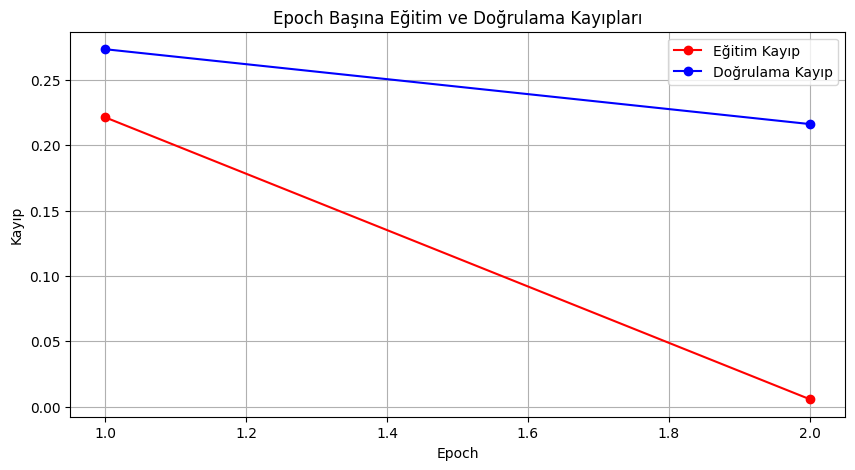

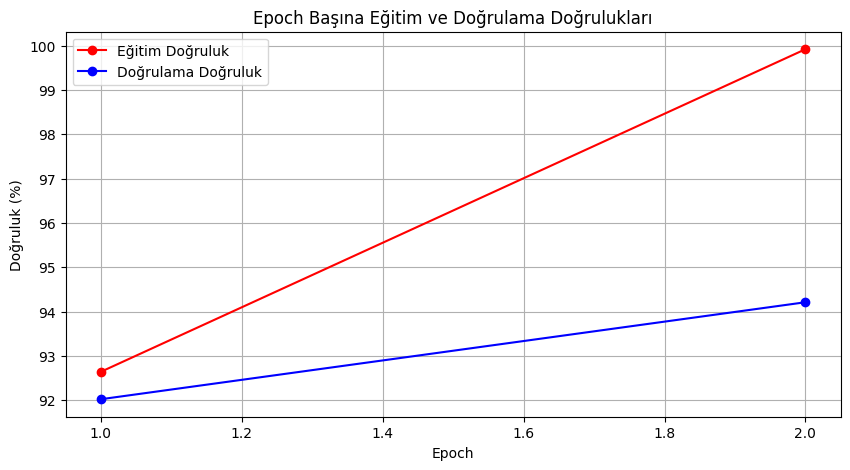

In [ ]:
import matplotlib.pyplot as plt

epoklar = range(1, numEpochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epoklar, [float(kayıp) for kayıp in egitimKayıpListesi], label='Eğitim Kayıp', marker='o', linestyle='-', color='red')
plt.plot(epoklar, [float(kayıp) for kayıp in dogrulamaKayıpListesi], label='Doğrulama Kayıp', marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Epoch Başına Eğitim ve Doğrulama Kayıpları')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoklar, [float(doğruluk) for doğruluk in egitimDogrulukListesi], label='Eğitim Doğruluk', marker='o', linestyle='-', color='red')
plt.plot(epoklar, [float(doğruluk) for doğruluk in dogrulamaDogrulukListesi], label='Doğrulama Doğruluk', marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.title('Epoch Başına Eğitim ve Doğrulama Doğrulukları')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch

model_dosyasi = '/content/drive/My Drive/colabmodels/vitmodelson.pth'
kayit_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'egitimKayıpListesi': egitimKayıpListesi,
    'dogrulamaKayıpListesi': dogrulamaKayıpListesi,
    'egitimDogrulukListesi': egitimDogrulukListesi,
    'dogrulamaDogrulukListesi': dogrulamaDogrulukListesi
}

torch.save(kayit_dict, model_dosyasi)
print(f'Model ve eğitim verileri başarıyla {model_dosyasi} dosyasına kaydedildi.')


Model ve eğitim verileri başarıyla /content/drive/My Drive/colabmodels/vitmodelson.pth dosyasına kaydedildi.


KAYNAK


https://huggingface.co/docs/transformers/model_doc/vit


https://www.youtube.com/watch?v=nTlLAS7N7qE&list=PLv8Cp2NvcY8DLQc0vBk7JS3FpX6dgNKWI

